# AMATH 515 Homework 2

**Due Date: 02/19/2020**

*Homework Instruction*: Please follow order of this notebook and fill in the codes where commented as `TODO`.

In [1]:
UW_ID = "1772371"
FIRST_NAME = "Philip"
LAST_NAME = "Pham"

In [2]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

## Please complete the solvers in `solver.py`

In [3]:
import sys
sys.path.append('./')
from solvers import *

## Problem 3: Compressive Sensing

Consier the optimization problem,

$$
\min_x~~\frac{1}{2}\|Ax - b\|^2 + \lambda\|x\|_1
$$

In the following, please specify the $f$ and $g$ and use the proximal gradient descent solver to obtain the solution.

In [4]:
# create the data
np.random.seed(123)
m = 100  # number of measurements
n = 500  # number of variables
k = 10   # number of nonzero variables
s = 0.05 # measurements noise level
#
A_cs = np.random.randn(m, n)
x_cs = np.zeros(n)
x_cs[np.random.choice(range(n), k, replace=False)] = np.random.choice([-1.0, 1.0], k)
b_cs = A_cs.dot(x_cs) + s*np.random.randn(m)
#
lam_cs = 0.1*norm(A_cs.T.dot(b_cs), np.inf)

In [5]:
# define the function, prox and the beta constant
def func_f_cs(x):
    return np.sum(np.square(np.matmul(A_cs, x) - b_cs)) / 2.

def func_g_cs(x):
    return lam_cs * np.sum(np.abs(x))

def grad_f_cs(x):
    return np.matmul(A_cs.T, np.matmul(A_cs, x) - b_cs)

def prox_g_cs(x, t):
    delta = t * lam_cs
    return np.where(np.abs(x) >= delta, x - np.sign(x) * delta, 0.)
# Largest eigenvalue of Gramian matrix.
beta_f_cs = sorted(np.abs(np.linalg.eigvals(np.matmul(A_cs.T, A_cs))))[-1]

### Proximal gradient descent on compressive sensing

In [6]:
# apply the proximal gradient descent solver
x0_cs_pgd = np.zeros(x_cs.size)
x_cs_pgd, obj_his_cs_pgd, err_his_cs_pgd, exit_flag_cs_pgd = \
    optimizeWithPGD(x0_cs_pgd, func_f_cs, func_g_cs, grad_f_cs, prox_g_cs, beta_f_cs)

Text(0.5, 1.0, 'Compressive Sensing Signal')

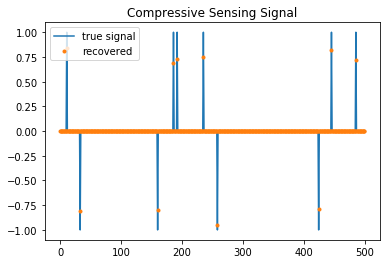

In [7]:
# plot signal result
plt.plot(x_cs)
plt.plot(x_cs_pgd, '.')
plt.legend(['true signal', 'recovered'])
plt.title('Compressive Sensing Signal')

Text(0.5, 0.98, 'Proximal Gradient Descent on Compressive Sensing')

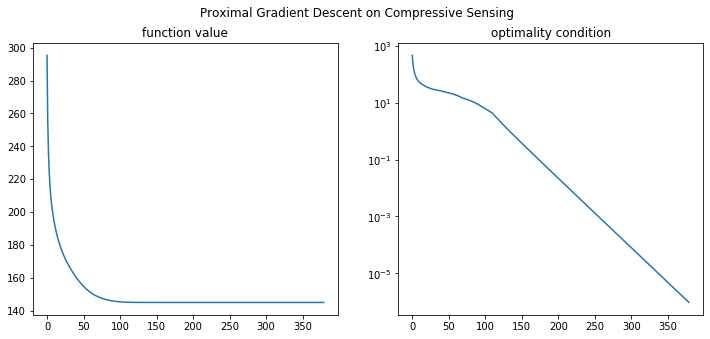

In [8]:
# plot result
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(obj_his_cs_pgd)
ax[0].set_title('function value')
ax[1].semilogy(err_his_cs_pgd)
ax[1].set_title('optimality condition')
fig.suptitle('Proximal Gradient Descent on Compressive Sensing')

### Accelerate proximal gradient descent on compressive sensing

In [9]:
# apply the proximal gradient descent solver
x0_cs_apgd = np.zeros(x_cs.size)
x_cs_apgd, obj_his_cs_apgd, err_his_cs_apgd, exit_flag_cs_apgd = \
    optimizeWithAPGD(x0_cs_apgd, func_f_cs, func_g_cs, grad_f_cs, prox_g_cs, beta_f_cs)

Text(0.5, 1.0, 'Compressive Sensing Signal')

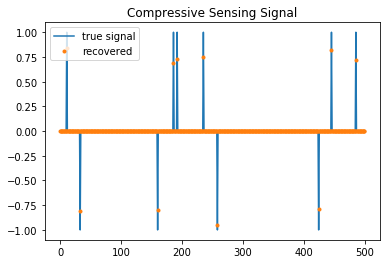

In [10]:
# plot signal result
plt.plot(x_cs)
plt.plot(x_cs_apgd, '.')
plt.legend(['true signal', 'recovered'])
plt.title('Compressive Sensing Signal')

Text(0.5, 0.98, 'Accelerated Proximal Gradient Descent on Compressive Sensing')

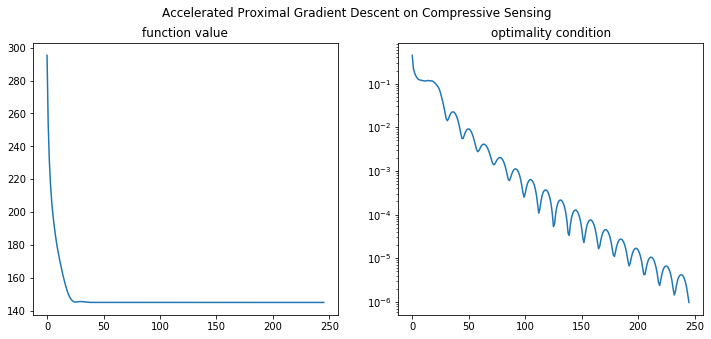

In [11]:
# plot result
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(obj_his_cs_apgd)
ax[0].set_title('function value')
ax[1].semilogy(err_his_cs_apgd)
ax[1].set_title('optimality condition')
fig.suptitle('Accelerated Proximal Gradient Descent on Compressive Sensing')

## Problem 4: Logistic Regression on MINST Data

Now let's play with some real data, recall the logistic regression problem,

$$
\min_x~~\sum_{i=1}^m\left\{\log(1 + \exp(\langle a_i,x \rangle)) - b_i\langle a_i,x \rangle\right\} + \frac{\lambda}{2}\|x\|^2.
$$

Here our data pair $\{a_i, b_i\}$, $a_i$ is the image and $b_i$ is the label.
In this homework problem, let's consider the binary classification problem, where $b_i \in \{0, 1\}$.

In [12]:
# import data
mnist_data = np.load('mnist01.npy', allow_pickle=True)
#
A_lgt = mnist_data[0]
b_lgt = mnist_data[1]
A_lgt_test = mnist_data[2]
b_lgt_test = mnist_data[3]
#
# set regularizer parameter
lam_lgt = 0.1
#
# beta constant of the function
beta_lgt = 0.25*norm(A_lgt, 2)**2 + lam_lgt

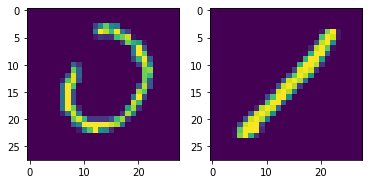

In [13]:
# plot the images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(A_lgt[0].reshape(28,28))
ax[1].imshow(A_lgt[7].reshape(28,28))

In [14]:
# define function, gradient and Hessian
def lgt_func(x):
    logits = np.matmul(A_lgt, x)
    return np.sum(np.log(1 + np.exp(logits)) - b_lgt * logits) + 0.5 * lam_lgt * np.sum(np.square(x))
#
def lgt_grad(x):
    logits = np.matmul(A_lgt, x)
    exp_logits = np.exp(logits)
    return np.sum(A_lgt.T * exp_logits / (1 + exp_logits), axis=1) - np.matmul(A_lgt.T, b_lgt) + lam_lgt * x
#
def lgt_hess(x):
    n_lgt = A_lgt.shape[-1]
    logits = np.matmul(A_lgt, x)
    exp_logits = np.exp(logits)
    rescaled_A_T = A_lgt.T * np.sqrt(exp_logits) / (1 + exp_logits)
    return np.matmul(rescaled_A_T, rescaled_A_T.T) + np.eye(n_lgt) * lam_lgt

### Gradient descent on logistic regression

In [15]:
# apply the gradient descent
x0_lgt_gd = np.zeros(A_lgt.shape[1])
x_lgt_gd, obj_his_lgt_gd, err_his_lgt_gd, exit_flag_lgt_gd = \
    optimizeWithGD(x0_lgt_gd, lgt_func, lgt_grad, beta_lgt)

Gradient descent reach maximum number of iteration.


Text(0.5, 0.98, 'Gradient Descent on Logistic Regression')

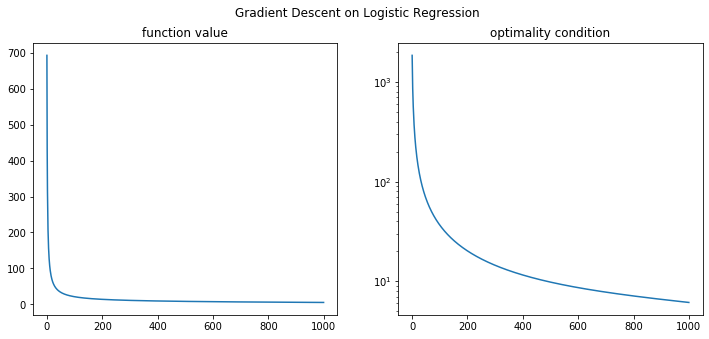

In [16]:
# plot result
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(obj_his_lgt_gd)
ax[0].set_title('function value')
ax[1].semilogy(err_his_lgt_gd)
ax[1].set_title('optimality condition')
fig.suptitle('Gradient Descent on Logistic Regression')

### Accelerate Gradient descent on logistic regression

In [17]:
# apply the accelerated gradient descent
x0_lgt_agd = np.zeros(A_lgt.shape[1])
x_lgt_agd, obj_his_lgt_agd, err_his_lgt_agd, exit_flag_lgt_agd = \
    optimizeWithAGD(x0_lgt_agd, lgt_func, lgt_grad, beta_lgt)

Accelerated gradient descent reach maximum of iteration


Text(0.5, 0.98, 'Accelerated Gradient Descent on Logistic Regression')

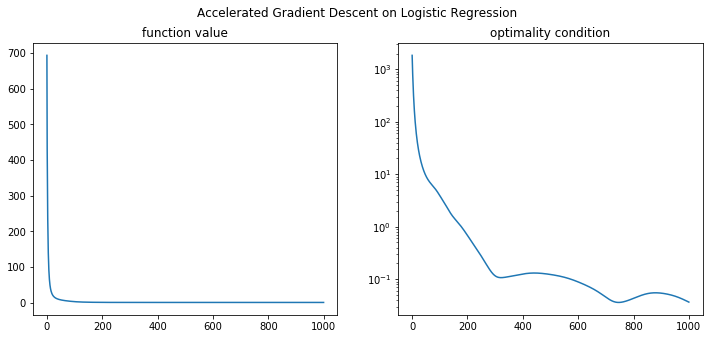

In [18]:
# plot result
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(obj_his_lgt_agd)
ax[0].set_title('function value')
ax[1].semilogy(err_his_lgt_agd)
ax[1].set_title('optimality condition')
fig.suptitle('Accelerated Gradient Descent on Logistic Regression')

### Newton's Method on logistic regression

In [19]:
# apply the accelerated gradient descent
x0_lgt_nt = np.zeros(A_lgt.shape[1])
x_lgt_nt, obj_his_lgt_nt, err_his_lgt_nt, exit_flag_lgt_nt = \
    optimizeWithNT(x0_lgt_nt, lgt_func, lgt_grad, lgt_hess)

Text(0.5, 0.98, "Newton's Method on Logistic Regression")

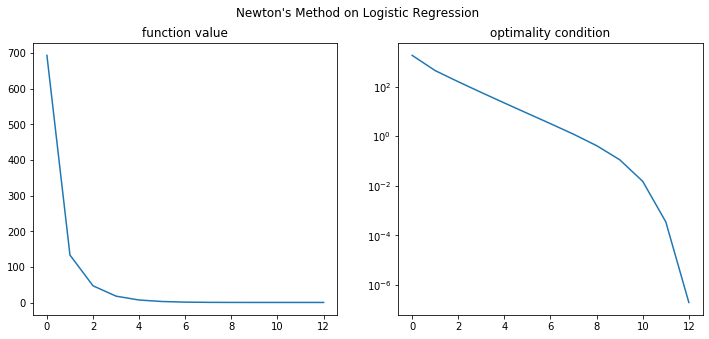

In [20]:
# plot result
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(obj_his_lgt_nt)
ax[0].set_title('function value')
ax[1].semilogy(err_his_lgt_nt)
ax[1].set_title('optimality condition')
fig.suptitle('Newton\'s Method on Logistic Regression')

### Test Logistic Regression

In [21]:
# define accuracy function
def accuracy(x, A_test, b_test):
    r = A_test.dot(x)
    b_test[b_test == 0.0] = -1.0
    correct_count = np.sum((r*b_test) > 0.0)
    return correct_count/b_test.size

In [22]:
print('accuracy of the result is %0.3f' % accuracy(x_lgt_nt, A_lgt_test, b_lgt_test))

accuracy of the result is 1.000
